<a href="https://colab.research.google.com/github/Mastaiah/Langraph/blob/main/LangGraph_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LangGraph is a library (framework) built on top of LangChain, designed to add cyclic computational capabilities to your LLM applications. While LangChain allows you to define chains of computation (Directed Acyclic Graphs or DAGs), LangGraph introduces the ability to add cycles, enabling more complex, agent-like behaviors where you can call an LLM in a loop, asking it what action to take next.

LangChain allows us to create DAGs (directed acyclic graphs).

While CrewAI is a high-level framework with many predefined features and ready-to-use components, LangGraph operates at a lower level, offering extensive customization and control.


Use LangChain if your app requires real-time external data retrieval (e.g., Chatbot fetching Wikipedia data).

Use LangGraph if your app requires structured decision-making workflows (e.g., Loan approval with conditions).


***Acyclic and Directed Acyclic Graph (DAG):***
  Acyclic means there are no cycles. A cycle happens when you can start from one point (node) in a graph, follow a sequence of edges (arrows), and return to the starting point.

  Directed means the edges (connections between nodes) have a direction (like a one-way street).
  
A Directed Acyclic Graph (DAG) is a graph where:

    Every edge has a direction.
    There are no cycles (no way to loop back to the starting point).

***Cyclic Graph:***
A cyclic graph is the opposite. It allows loops or cycles. For example, you can go from one node, follow the edges, and return to the same node.


LangChain → Open Loop 🔄 (One request → One response → Stops)

LangGraph → Closed Loop 🔁 (Keeps executing and adjusting decisions)

While LangChain allows the creation of Directed Acyclic Graphs (DAGs) for linear workflows, LangGraph takes this a step further by enabling the addition of cycles, which are essential for developing complex, agent-like behaviors.

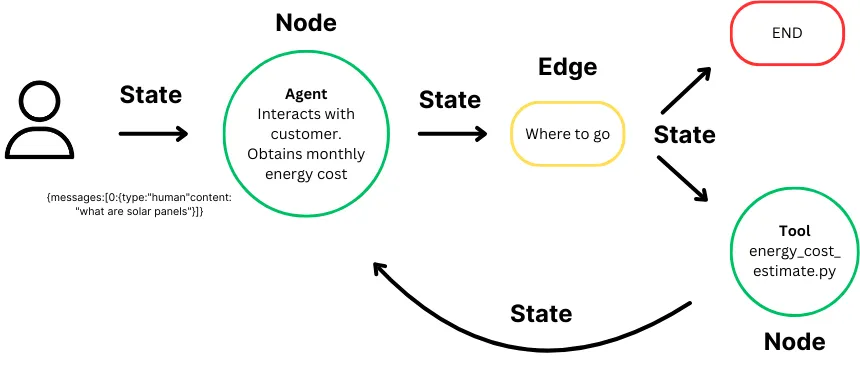

# ***Key Concepts***

  **StateGraph**: This is the main structure in LangGraph. It’s like a map that
shows how your AI should move from one task to another.

  **Nodes:** These are the individual tasks or actions in your AI workflow. Each node does a specific job, like asking a question processing input, makeing decision ,or interacting with external APIs ( Each node represents a function or a computation step).

  **Edges:** These connect the nodes and show how your AI should move between tasks. There are two types of edges in LangGraph:

    a. Standard Edges: These are simple, direct connections between nodes.
  
    b. Conditional Edges: These allow for dynamic routing based on the current state or the output of a node.

  **State:** This is like the AI’s memory. It keeps track of information as the AI moves through different tasks.


  **Conditional Edges:** These allow your AI to make decisions about which node to go to next based on the current state or the output of the previous node. They’re defined using a function that examines the state and returns the name of the next node to execute. This feature enables more complex and adaptive workflows, where the path through the graph can change based on the AI’s findings or user input.

In [ ]:
!pip install langgraph -q
!pip install langchain-community -q

In [ ]:
from typing import TypedDict, Optional
from langgraph.graph import StateGraph ,START, END
from IPython.display import Image, display

#### Step 1: Define the Graph State

In [ ]:
class GraphState(TypedDict):
  question: Optional[str] = None
  classification : Optional[str] = None
  response: Optional[str] = None


🧠 LangGraph-Specific Considerations

LangGraph is dataflow-oriented, and each node receives and returns structured data, typically via dictionaries or models.

Use TypedDict for:

    Internal wiring of the LangGraph state (lightweight state representation).
    Fast prototyping or when validation is unnecessary.

Use Pydantic for:

    Stateful agents with external inputs or complex validation.
    When interacting with LangChain, FastAPI, or other tools expecting BaseModel.
    When building reusable, introspectable components.

✅ Practical Rule of Thumb

“Use TypedDict for internal structures. Use Pydantic when the structure crosses boundaries (e.g., user input, tool input/output, or persisted state).”

#### Step 2: Create the Graph

In [ ]:
workflow = StateGraph(GraphState)

In [ ]:
#Helper function , not an node function
def classify(question:str) -> str:
  if any ( word in question for word in ["hi", "hello", "hey"]):
    return "handle_greeting"


#### Step 3: Define Nodes

In [ ]:
def classify_input_node(state):
  question = state.get('question','').strip().lower()
  classification = classify (question)
  return {"classification":classification}


[ user input ]

      ↓
[classify_input]  ← (this is a node)

      ↓
[??? next ???] ← LangGraph doesn’t know where to go until you DECIDE
You use add_conditional_edges() to tell LangGraph:


"After the classify_input step is done, run the decide_next_node() function, and depending on what it returns, go to the next appropriate node."

In [ ]:
def handle_greeting_node(state):
  return {"response":"Hello! How can I assist you today?"}

In [ ]:
def handle_search_node(state):
  question = state.get('question','').strip()
  search_result = f"Search result for '{question}'"
  return {"response":search_result}

#### Step 4: Add Nodes to the Graph

In [ ]:
#normal edges
# Check if node exists before adding it
if "classify_input" not in workflow.nodes:
  workflow.add_node("classify_input", classify_input_node)

if "handle_greeting" not in workflow.nodes:
  workflow.add_node("handle_greeting", handle_greeting_node)

if "handle_search" not in workflow.nodes:
  workflow.add_node("handle_search", handle_search_node)


def decide_next_node(state):
  return "greeting" if state.get('classification') == "handle_greeting" else "search"


#Conditional edges.
# Check if the conditional edges already exist before adding them
if "decide_next_node" not in workflow.branches.get("classify_input", {}):
  workflow.add_conditional_edges(
      source = "classify_input",   # The node where the decision happens
      path =  decide_next_node,    # The function that determines the next step
      path_map = {
          "greeting":"handle_greeting",
          "search":"handle_search",
      }
)


1. Run classify_input          <-- source
2. Run decide_next_node       <-- path
3. Look at return value (e.g., "greeting")
4. Go to path_map["greeting"] → handle_greeting


#### Step 5: Set Entry and End Points

How LangGraph expects node functions to behave:

Each node function receives the current state as input (usually a dict or TypedDict).

The function should return a dictionary containing only the changes it wants to apply to the state.

LangGraph merges these returned updates into the full state automatically after the node finishes.

In [ ]:
workflow.set_entry_point("classify_input")
workflow.add_edge('handle_greeting', END)
workflow.add_edge('handle_search', END)

#### Step 6: Compile and Run the Graph

In [ ]:
app = workflow.compile()
inputs = {"question": "how are you?"}
result = app.invoke(inputs)


# Remove 'classification' from the result before printing
filtered_result = {key: value for key, value in result.items() if key != "classification"}
print(filtered_result)

{'question': 'how are you?', 'response': "Search result for 'how are you?'"}


#### Printing the graph as PNG

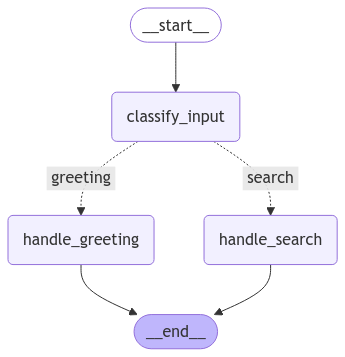

In [ ]:
from IPython.display import Image, display

# Assuming you have already created and compiled your graph as 'app'
png_graph = app.get_graph().draw_mermaid_png()
display(Image(png_graph))

#### Saving the PNG file

In [ ]:
import os

png_graph = app.get_graph().draw_mermaid_png()
with open("my_graph.png", "wb") as f:
    f.write(png_graph)

print(f"Graph saved as 'my_graph.png' in {os.getcwd()}")

Graph saved as 'my_graph.png' in /content


***State Management*** : Remember that each node receives the current state, can modify it, and passes it on to the next node.

***Conditional Edges:*** Setting up conditional edges requires careful consideration of the conditions and the mapping of outcomes to the next nodes. Ensure that the keys returned by the condition function match the keys in the conditional edge mapping

***Dead-End Nodes:*** Every node in the graph should have a path leading to another node or to the END node. If a node has no outgoing edges, it's considered a dead-end, and you'll need to add an edge to avoid errors.
